<a href="https://colab.research.google.com/github/wai-ming-chan/fed_avg/blob/main/Fed_test_%5Bnot_working_in_Colab%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## environment setup

In [1]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()


In [2]:
%load_ext tensorboard

In [4]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

# tff.federated_computation(lambda: 'Hello, World!')()

## Preparing the input data

In [5]:
# Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.
# Load Input data
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()


In [6]:
len(emnist_train.client_ids)


3383

In [7]:
emnist_train.element_type_structure


OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [56]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[300])

example_arrays=iter(example_dataset)


for x in range(12):
  example_element = next(example_arrays)
  print('label:', example_element['label'].numpy())
  


label: 1
label: 0
label: 2
label: 7
label: 9
label: 1
label: 5
label: 1
label: 1
label: 1
label: 6
label: 1


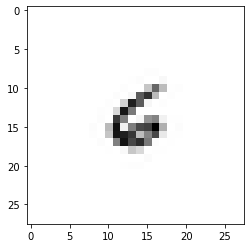

In [43]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()


### Exploring heterogeneity in federated data

let's grab a sampling of one client's data to get a feel for the examples on one simulated device. Because the dataset we're using has been keyed by unique writer, the data of one client represents the handwriting of one person for a sample of the digits 0 through 9, simulating the unique "usage pattern" of one user.

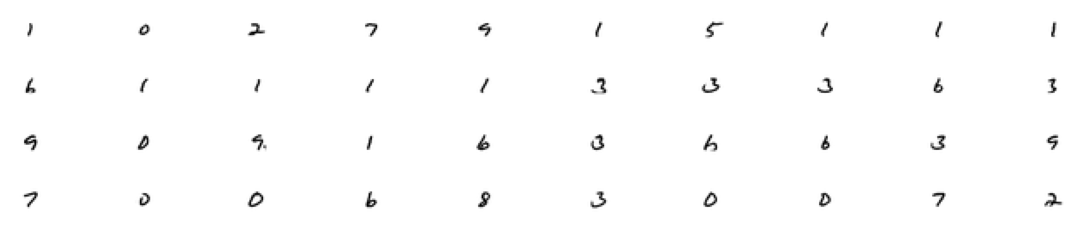

In [57]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

Now let's visualize the number of examples on each client for each MNIST digit label.

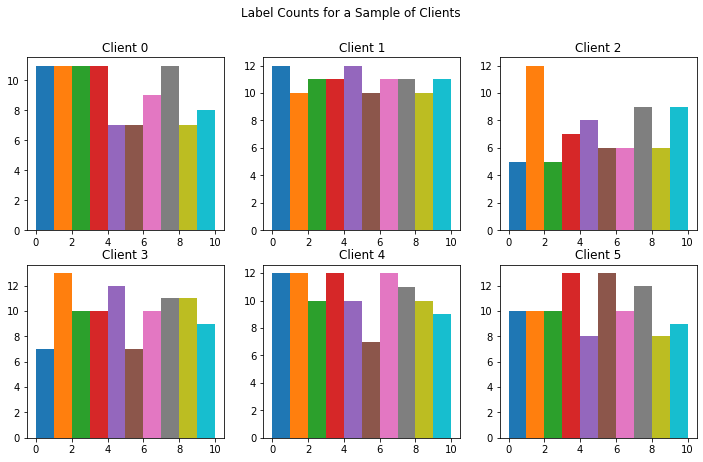

In [58]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Now let's visualize the mean image per client for each MNIST label. 

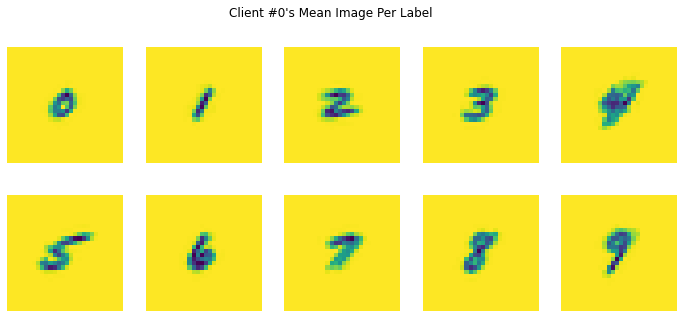

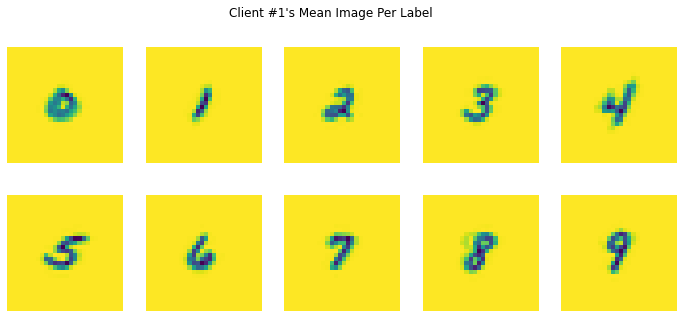

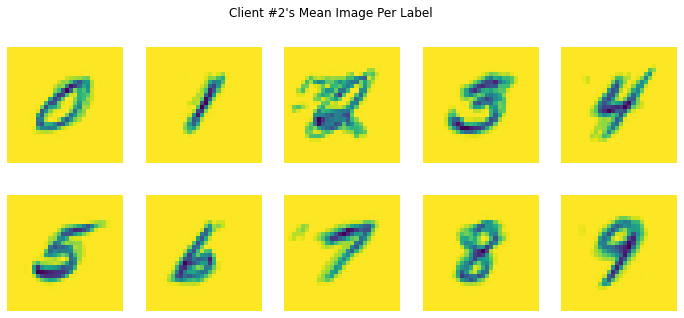

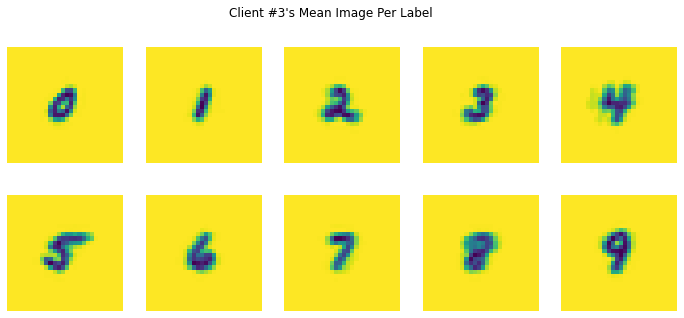

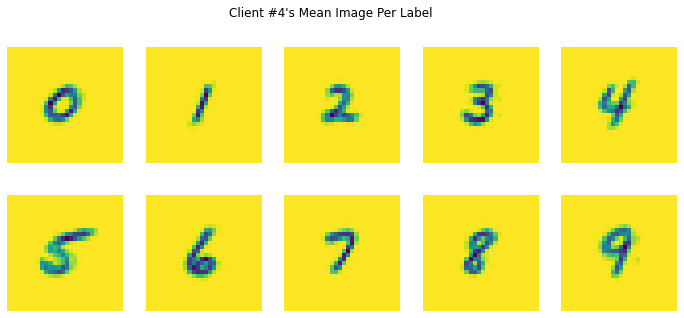

In [59]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

## Preprocessing the input data

Here, we flatten the 28x28 images into 784-element arrays, shuffle the individual examples, organize them into batches, and rename the features from pixels and label to x and y for use with Keras. We also throw in a repeat over the data set to run several epochs.

In [60]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

Let's verify this worked.

In [61]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[9],
                     [1],
                     [6],
                     [0],
                     [1],
                     [2],
                     [0],
                     [5],
                     [2],
                     [2],
                     [9],
                     [9],
                     [6],
                     [7],
                     [4],
                     [1],
                     [1],
                     [5],
                     [2],
                     [2]], dtype=int32))])

This is helper function that will construct a list of datasets from the given set of users as an input to a round of training or evaluation.

In [62]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

Of course, we are in a simulation environment, and all the data is locally available. Typically then, when running simulations, we would simply sample a random subset of the clients to be involved in each round of training, generally different in each round.

That said, as you can find out by studying the paper on the Federated Averaging algorithm, achieving convergence in a system with randomly sampled subsets of clients in each round can take a while, and it would be impractical to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and reuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data). 

In [63]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 10
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


## Creating a model with Keras

In [64]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [65]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Training the model on federated data

In [66]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [67]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[784,10],
    float32[10]
  >
>@SERVER)


Let's invoke the initialize computation to construct the server state.

Same error "UnsupportedOperation: fileno" reported as [https://github.com/tensorflow/federated/issues/3724](https://github.com/tensorflow/federated/issues/3724)

In [69]:
train_state = training_process.initialize()

UnsupportedOperation: ignored

In [70]:


result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

NameError: ignored